In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F # módulo para aplicar funções de ativação, custo, convolução etc diretamente em tensores
from torch.autograd import Variable 
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import numpy as np
from torch.optim import AdamW

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
data_folder = '/kaggle/working/'
trn_ds = MNIST(data_folder, transform=transforms.ToTensor(), download=True, train=True)
val_ds = MNIST(data_folder, transform=transforms.ToTensor(), download=True, train=False)

In [12]:
trn_ds.data.shape

torch.Size([60000, 28, 28])

In [13]:
trn_dl = DataLoader(trn_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 32, shuffle=False)

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # rede encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc21 = nn.Linear(256, 20)  # média
        self.fc22 = nn.Linear(256, 20)  # logvar
        
        # rede decoder
        self.fc3 = nn.Linear(20, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
    
    # definindo a rede encoder funcionalmente
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = Variable(torch.randn(std.size())).cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    # define a rede decode funcionalmente
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z
    
    # define o fluxo do tensor x ao longo do autoencoder
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar


In [23]:
# função de treino com batch
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss.item(), mse, kld, log_var.mean(), mean.mean()

# função de validação por batch
@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss.item(), mse, kld, log_var.mean(), mean.mean()

In [24]:
# função de custo para a VAE
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

0
1
2
3
4
5
6
7
8
9


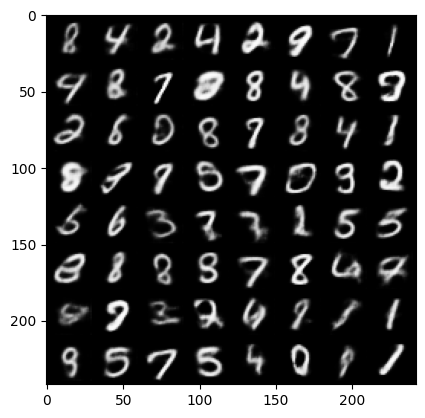

In [31]:
import matplotlib.pyplot as plt
n_epochs = 10
vae = VAE().to(device)
optimizer = AdamW(vae.parameters(), lr=1e-3)
train_epoch_losses, val_epoch_losses = [], []


for epoch in range(n_epochs):
    print(epoch)
    train_batch_losses, val_batch_losses = [], []
    
    for batch_idx, (data, _) in enumerate(trn_dl):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        train_batch_losses.append(loss)
    train_epoch_losses.append(np.array(train_batch_losses).mean())
        
    for batch_idx, (data, _) in enumerate(val_dl):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        val_batch_losses.append(loss)
    val_epoch_losses.append(np.array(val_batch_losses).mean())
    
    with torch.no_grad():
        z = torch.randn(64, 20).to(device)
        sample = vae.decode(z).cpu()
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        plt.imshow(images, cmap='gray')

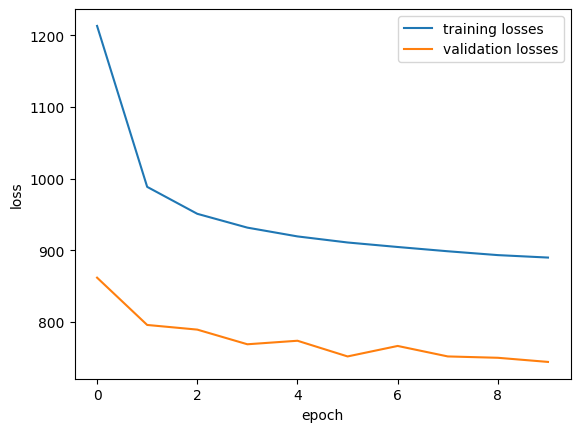

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_losses, label = "training losses")
plt.plot(val_epoch_losses, label = 'validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()